In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("../")

%pylab inline
import torch
import torch
from deepflow.utils import set_seed
from deepflow.utils import load_generator
from deepflow.plotting_utils import colorbar
from tqdm import tqdm_notebook as tqdm

Populating the interactive namespace from numpy and matplotlib


In [2]:
plot = True
# inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 8, # fontsize for x and y labels (was 10)
    'axes.titlesize': 8,
    'font.size': 8, # was 10
    'legend.fontsize': 6, # was 10
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'figure.figsize': [14, 12],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [3]:
test_data = np.load("./dataset/test_half_circle_facies_vp_rho.npy")

In [4]:
test_data_th =  torch.from_numpy(test_data)
print(test_data_th.size())

torch.Size([4096, 3, 64, 128])


In [5]:
test_model = test_data_th[67]

In [6]:
def permeability_transform(x, a=0.001, b=1e-12): #c=0.3, d=0.1
    return (x+a)*b

def porosity_transform(x, c=0.3, d=0.1):
    return (x*c)+d

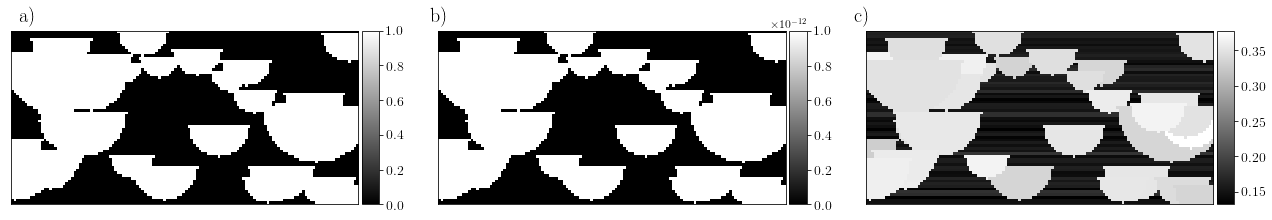

In [30]:
plot = True
# inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'figure.figsize': [14, 12],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

fig, ax = plt.subplots(1, 3, figsize=(6*3, 6)) 
a1 = ax[0].imshow(test_model[0].numpy()[::-1], vmin=0, vmax=1)
cbar1 = colorbar(a1)
a2 = ax[1].imshow(permeability_transform(test_model[0].numpy()[::-1]), vmin=0)
cbar2 = colorbar(a2)
a3 = ax[2].imshow(porosity_transform(test_model[1].numpy()[::-1]))
cbar3 = colorbar(a3)
fig.tight_layout()

plt.text(-16.8, 0.39, "a)", fontsize=20)
plt.text(-11, 0.39, "b)", fontsize=20)
plt.text(-5, 0.39, "c)", fontsize=20)

cbar1.ax.tick_params(labelsize=14) 
cbar2.ax.tick_params(labelsize=14) 
cbar3.ax.tick_params(labelsize=14) 

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

if plot:
    plt.savefig("./results/figures/gt_model_overview.png", dpi=300, bbox_inches="tight")

In [8]:
test_facies = test_data[:, 0]
test_permeability = permeability_transform(test_data[:, 0])
test_porosity = porosity_transform(test_data[:, 1])

k_min, k_max = test_permeability.min(), test_permeability.max()
p_min, p_max = test_porosity.min(), test_porosity.max()

k_mean, k_std = test_permeability.mean(), test_permeability.std()
p_mean, p_std = test_porosity.mean(), test_porosity.std()

In [9]:
print(test_permeability.min(), test_permeability.max(), test_permeability.mean(), test_permeability.std())
print(test_porosity.min(), test_porosity.max(), test_porosity.mean(), test_porosity.std())

1e-15 1.0009999999999999e-12 4.598573873043056e-13 4.983044103964692e-13
0.10292618267260262 0.3975621027347337 0.244497109246783 0.09838563383727746


In [10]:
generator = load_generator("./checkpoints/generator_facies_multichannel_4_6790.pth")
pdf = torch.distributions.Normal(0, 1)

In [11]:
set_seed(42)
generator_permeability, generator_porosity, generator_facies = [], [], []
for i in tqdm(range(128)):
    with torch.no_grad():
        z = pdf.sample((32, 50, 1, 2))
        k, poro, x = generator(z)
        generator_permeability.append(k)
        generator_porosity.append(poro)
        generator_facies.append(x)

generator_permeability = torch.cat(generator_permeability, 1)[0]
generator_porosity = torch.cat(generator_porosity, 1)[0]
generator_facies = torch.cat(generator_facies, 0)

print(generator_permeability.size(), generator_porosity.size(), generator_facies.size())


torch.Size([4096, 128, 64]) torch.Size([4096, 128, 64]) torch.Size([4096, 128, 64])


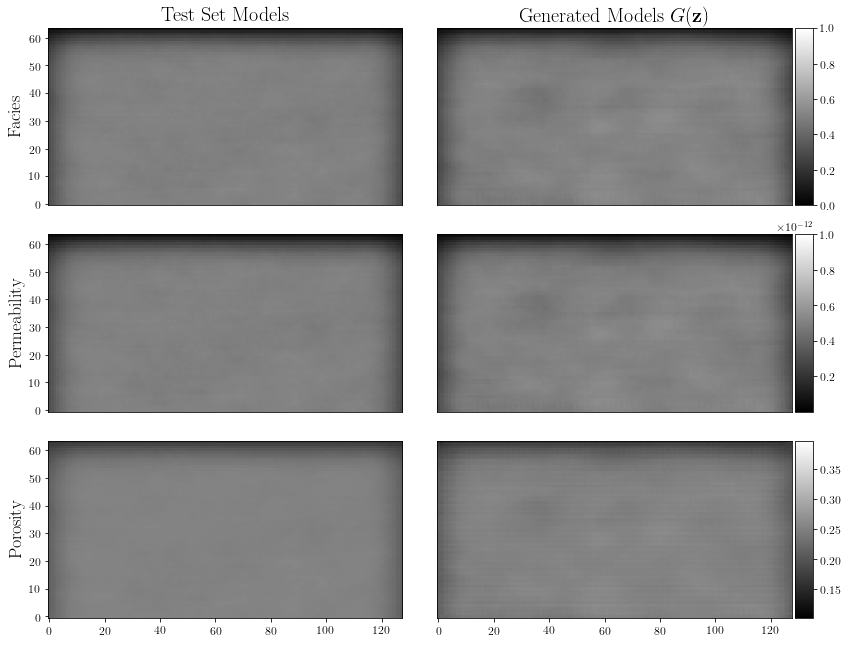

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(3*4, 3*3))

ax1 = ax[0, 0].imshow(test_facies.mean(0)[::-1], vmin=0, vmax=1, cmap="gray")
ax[0, 0].set_xticks([])
ax[0, 0].set_title("Test Set Models", fontsize=20)
ax[0, 0].set_ylabel("Facies", fontsize=18)

ax[1, 0].imshow(test_permeability.mean(0)[::-1], vmin=k_min, vmax=k_max, cmap="gray")
ax[1, 0].set_xticks([])
ax[1, 0].set_ylabel("Permeability", fontsize=18)


ax3 = ax[2, 0].imshow(test_porosity.mean(0)[::-1], vmin=p_min, vmax=p_max, cmap="gray")
ax[2, 0].set_ylabel("Porosity", fontsize=18)


a1 = ax[0, 1].imshow(generator_facies.mean(0).numpy().T[::-1], vmin=0, vmax=1, cmap="gray")
colorbar(a1)
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])
ax[0, 1].set_title("Generated Models $G(\mathbf{z})$", fontsize=20)

a2 = ax[1, 1].imshow(generator_permeability.mean(0).numpy().T[::-1], vmin=k_min, vmax=k_max, cmap="gray")
colorbar(a2)
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

a3 = ax[2, 1].imshow(generator_porosity.mean(0).numpy().T[::-1], vmin=p_min, vmax=p_max, cmap="gray")
colorbar(a3)

ax[2, 1].set_yticks([])
fig.tight_layout()

if plot:
    plt.savefig("./results/figures/spatial_mean_comparison.png", dpi=300, bbox_inches="tight")

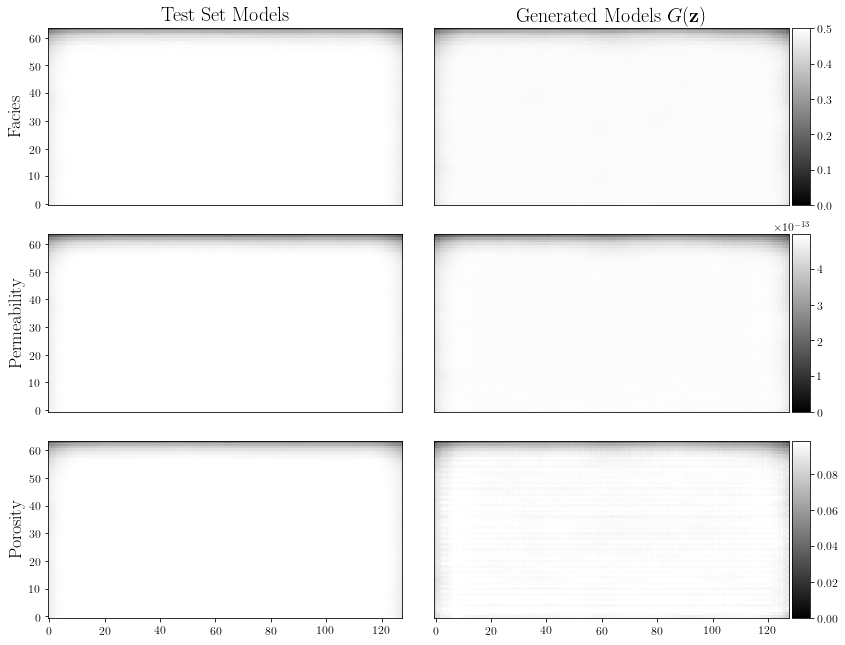

In [13]:
fig, ax = plt.subplots(3, 2, figsize=(3*4, 3*3))
sigma = 1
ax1 = ax[0, 0].imshow(test_facies.std(0)[::-1], vmin=0, vmax=0.5, cmap="gray")
ax[0, 0].set_xticks([])
ax[0, 0].set_title("Test Set Models", fontsize=20)
ax[0, 0].set_ylabel("Facies", fontsize=18)

ax[1, 0].imshow(test_permeability.std(0)[::-1], vmin=0, vmax=sigma*k_std, cmap="gray")
ax[1, 0].set_xticks([])
ax[1, 0].set_ylabel("Permeability", fontsize=18)


ax3 = ax[2, 0].imshow(test_porosity.std(0)[::-1], vmin=0, vmax=sigma*p_std, cmap="gray")
ax[2, 0].set_ylabel("Porosity", fontsize=18)


a1 = ax[0, 1].imshow(generator_facies.std(0).numpy().T[::-1], vmin=0, vmax=0.5, cmap="gray")
colorbar(a1)
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])
ax[0, 1].set_title("Generated Models $G(\mathbf{z})$", fontsize=20)

a2 = ax[1, 1].imshow(generator_permeability.std(0).numpy().T[::-1], vmin=0, vmax=sigma*k_std, cmap="gray")
colorbar(a2)
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

a3 = ax[2, 1].imshow(generator_porosity.std(0).numpy().T[::-1], vmin=0, vmax=sigma*p_std, cmap="gray")
colorbar(a3)

ax[2, 1].set_yticks([])
fig.tight_layout()

if plot:
    plt.savefig("./results/figures/spatial_std_comparison.png", dpi=300, bbox_inches="tight")

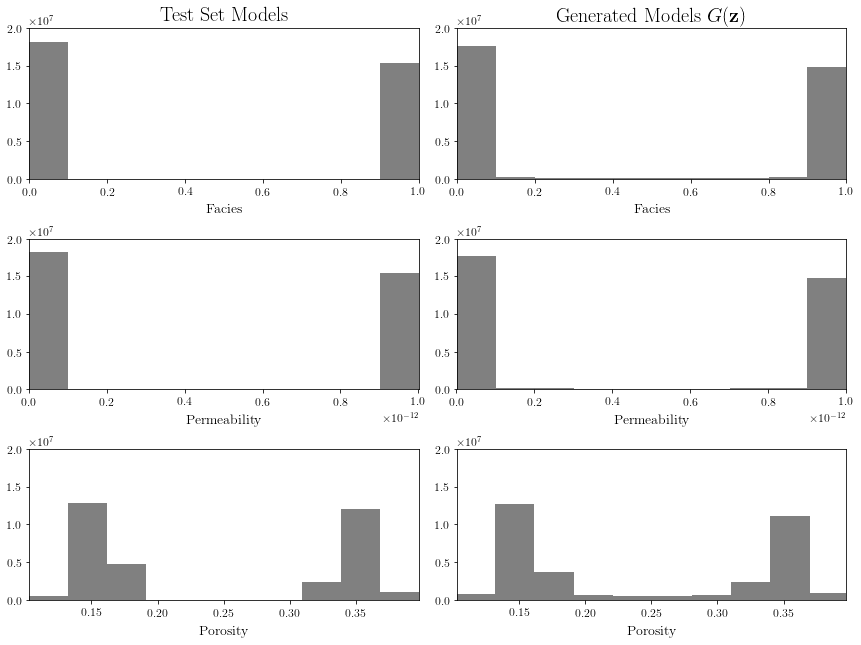

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(3*4, 3*3))

ax[0, 0].hist(test_facies.flatten(), color="gray")
ax[0, 0].set_xlim(0, 1)
ax[0, 0].set_title("Test Set Models", fontsize=20)
ax[0, 0].set_xlabel("Facies", fontsize=14)

ax[1, 0].hist(test_permeability.flatten(), color="gray")
ax[1, 0].set_xlim(k_min, k_max)
ax[1, 0].set_xlabel("Permeability", fontsize=14)

ax[2, 0].hist(test_porosity.flatten(), color="gray")
ax[2, 0].set_xlim(p_min, p_max)
ax[2, 0].set_xlabel("Porosity", fontsize=14)


ax[0, 1].hist(generator_facies.flatten(), color="gray")
ax[0, 1].set_title("Generated Models $G(\mathbf{z})$", fontsize=20)
ax[0, 1].set_xlabel("Facies", fontsize=14)
ax[0, 1].set_xlim(0, 1)

ax[1, 1].hist(generator_permeability.flatten(), color="gray")
ax[1, 1].set_xlim(k_min, k_max)
ax[1, 1].set_xlabel("Permeability", fontsize=14)

ax[2, 1].hist(generator_porosity.flatten(), color="gray")
ax[2, 1].set_xlim(p_min, p_max)
ax[2, 1].set_xlabel("Porosity", fontsize=14)

for a in ax.flatten():
    a.set_ylim(0, 2e7)

fig.tight_layout()
if plot:
    plt.savefig("./results/figures/histogram_properties_comparison.png", dpi=300, bbox_inches="tight")

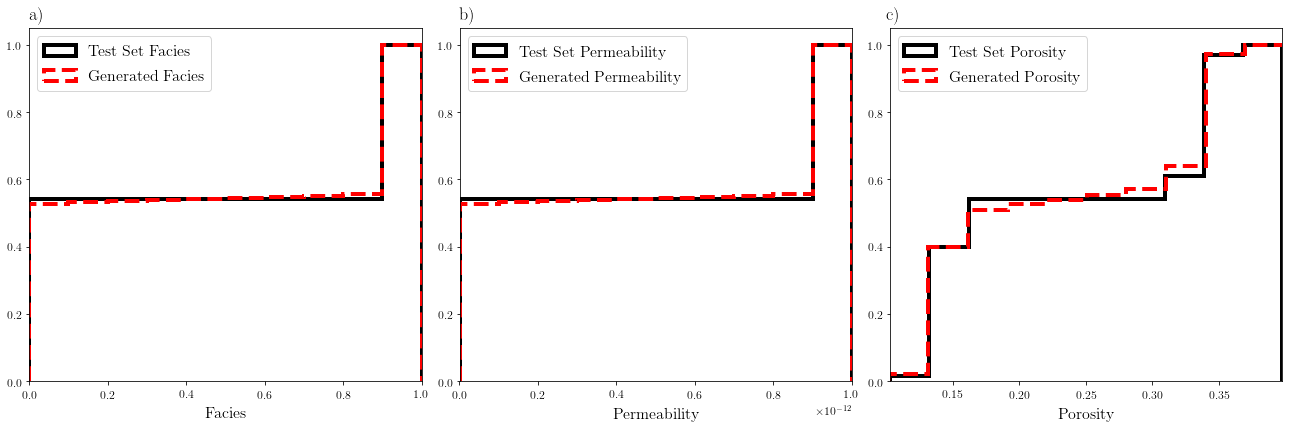

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(6*3, 6*1))

lw = 4
ax[0].hist(test_facies.flatten(), density=True, histtype='step',
                           cumulative=True, label='Test Set Facies', color="black", linewidth=lw)
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Facies", fontsize=16)


ax[1].hist(test_permeability.flatten(), density=True, histtype='step',
                           cumulative=True, label='Test Set Permeability', color="black", linewidth=lw)
ax[1].set_xlim(k_min, k_max)
ax[1].set_xlabel("Permeability", fontsize=16)

ax[2].hist(test_porosity.flatten(), density=True, histtype='step',
                           cumulative=True, label='Test Set Porosity', color="black", linewidth=lw)
ax[2].set_xlim(p_min, p_max)
ax[2].set_xlabel("Porosity", fontsize=16)


ax[0].hist(generator_facies.flatten(), density=True, histtype='step',
                           cumulative=True, label='Generated Facies', color="red", linestyle="--", linewidth=lw)


ax[1].hist(generator_permeability.flatten(), density=True, histtype='step',
                           cumulative=True, label='Generated Permeability', color="red", linestyle="--", linewidth=lw)


ax[2].hist(generator_porosity.flatten(), density=True, histtype='step',
                           cumulative=True, label='Generated Porosity', color="red", linestyle="--", linewidth=lw)

for a in ax.flatten():
    a.legend(fontsize=16, loc=2)

for a, label, left in zip(ax, ["a)", "b)", "c)"], [0.0, 0.0, 0.10]):
    a.text(left, 1.075, label, fontsize=18)
    
fig.tight_layout()
if plot:
    plt.savefig("./results/figures/cdf_properties_comparison.png", dpi=300, bbox_inches="tight")